In [1]:
from matplotlib import pyplot as plt
import numpy as np
from jax import numpy as jnp
from jax import random

from jaxpower.utils import TophatPowerToCorrelation, BesselPowerToCorrelation, Interpolator1D
from jaxpower import compute_normalization, ParticleField, MeshAttrs, BinAttrs

In [2]:
mattrs = MeshAttrs(boxsize=1500, meshsize=64)
kinedges = jnp.linspace(0., 1.01 * np.sqrt(3) * mattrs.knyq.max(), 200)
#kinedges = np.linspace(0., mattrs.knyq[0], 200)
kin = (kinedges[:-1] + kinedges[1:]) / 2.

def run(kinlim):
    mask = (kin >= kinlim[0]) & (kin < kinlim[1])
    pkin = 1. * mask
    
    # Return mesh painted with selection function
    def gaussian_survey(boxsize=2000., meshsize=128, boxcenter=0., size=int(1e7), seed=random.key(42), scale=0.24, paint=False):
        # Generate Gaussian-distributed positions
        positions = scale * random.normal(seed, shape=(size, 3))
        bscale = scale  # cut at 1 sigmas
        mask = jnp.all((positions > -bscale) & (positions < bscale), axis=-1)
        positions = positions * boxsize + boxcenter
        toret = ParticleField(positions, weights=1. * mask, boxcenter=boxcenter, boxsize=boxsize, meshsize=meshsize)
        if paint: toret = toret.paint(resampler='cic', interlacing=1, compensate=True)
        return toret
    
    selection = gaussian_survey(**mattrs, paint=True)
    norm = compute_normalization(selection, selection)
    selection = selection.r2c()
    selection = (selection * selection.conj()).c2r()
    selection /= norm  # window function, \sum_d F(d) F(d + s)
    
    def kernel(value, kvec):
        knorm = jnp.sqrt(sum(kk**2 for kk in kvec))
        interp = Interpolator1D(kinedges, knorm, order=0, edges=True)  # binning, interp(pkin) return P(k) at knorm
        return interp(pkin) / mattrs.cellsize.prod()

    # Here I compute windowed P as the mesh product xi * selection
    mesh = mattrs.create(kind='complex').apply(kernel, kind='wavenumber')
    kbin = BinAttrs(mesh, edges=kinedges)
    mesh = mesh.c2r() * selection  # xi * selection
    sbin = BinAttrs(mesh)
    xi_fft = sbin(mesh)
    pk_fft = kbin(mesh.r2c())
    
    # Here I interpolate 1D xi obtained above on the grid
    snorm = jnp.sqrt(sum(xx**2 for xx in mesh.coords(kind='separation', sparse=True)))
    interp = Interpolator1D(sbin.edges, snorm, order=0, edges=True)
    mesh = mesh.clone(value=interp(xi_fft))
    xi_1d = sbin(mesh)
    pk_1d = kbin(mesh.r2c())
    
    # Here I take the spherical Bessel transform of input power, summing over k's of the 3D mesh
    kbin_unique = BinAttrs(mesh.r2c())
    bessel = BesselPowerToCorrelation(kbin_unique.xavg, sbin.xavg, ell=0, volume=mattrs.kfun.prod() * kbin_unique.nmodes)
    xi_bessel = bessel(Interpolator1D(kinedges, kbin_unique.xavg, order=0, edges=True)(pkin))
    mesh = mesh.clone(value=interp(xi_bessel).astype(mesh.dtype) * selection.value)
    xi_bessel = sbin(mesh)
    pk_bessel = kbin(mesh.r2c())
    
    # Here I take the spherical Bessel transform of input power, summing over the exact transform of tophat functions
    # i.e. *exactly* eq. 50 of https://www.overleaf.com/8752336385dvwtqkknwnrv
    tophat = TophatPowerToCorrelation(kinedges, sbin.xavg, edges=True)
    xi_tophat = tophat(pkin)
    mesh = mesh.clone(value=interp(xi_tophat).astype(mesh.dtype) * selection.value)
    xi_tophat = sbin(mesh)
    pk_tophat = kbin(mesh.r2c())
    return pkin, (sbin, xi_fft, xi_bessel, xi_tophat), (kbin, pk_fft, pk_bessel, pk_tophat)

kinlims = [(0.1, 0.1 * 1.01), (1.2 * mattrs.knyq.max(), 1.2 * mattrs.knyq.max() * 1.01)]    
results = [run(kinlim) for kinlim in kinlims]


/local/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


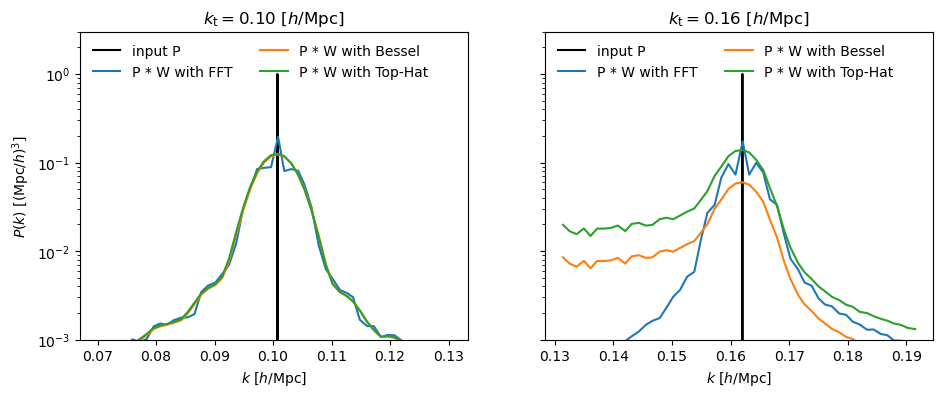

In [3]:
if False:
    fig, lax = plt.subplots(1, len(results), sharey=True, figsize=(11, 4))
    for i, kinlim in enumerate(kinlims):
        ax = lax[i]
        (sbin, xi_fft, xi_bessel, xi_tophat) = results[i][1]
        title = r'$k_\mathrm{{t}} = {:.2f}$ [$h/\mathrm{{Mpc}}$]'.format(np.mean(kinlim))
        ax.set_title(title)
        ax.plot(sbin.xavg, sbin.xavg**2 * xi_fft, label=r'$\xi$ with FFT')
        ax.plot(sbin.xavg, sbin.xavg**2 * xi_bessel, label=r'$\xi$ with Bessel')
        ax.plot(sbin.xavg, sbin.xavg**2 * xi_tophat, label=r'$\xi$ with Top-Hat')
        ax.set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
        if i == 0: ax.set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
        ax.legend(frameon=False, ncols=2, loc=2)
    plt.show()

if True:
    fig, lax = plt.subplots(1, len(results), sharey=True, figsize=(11, 4))
    for i, kinlim in enumerate(kinlims):
        ax = lax[i]
        pkin = results[i][0]
        (kbin, pk_fft, pk_bessel, pk_tophat) = results[i][2]
        title = r'$k_\mathrm{{t}} = {:.2f}$ [$h/\mathrm{{Mpc}}$]'.format(np.mean(kinlim))
        ax.set_title(title)
        kolim = kinlim[0] - 0.03, kinlim[1] + 0.03
        mask = (kin > kolim[0]) & (kin < kolim[1])
        ax.plot(kin[mask], pkin[mask], color='k', label='input P')
        mask = (kbin.xavg > kolim[0]) & (kbin.xavg < kolim[1])
        ax.plot(kbin.xavg[mask], pk_fft[mask], label='P * W with FFT')
        ax.plot(kbin.xavg[mask], pk_bessel[mask], label='P * W with Bessel')
        ax.plot(kbin.xavg[mask], pk_tophat[mask], label='P * W with Top-Hat')
        #ax.set_ylim(-0.01, 0.4)
        ax.set_ylim(1e-3, 3.)
        ax.set_yscale('log')
        #ax.grid(True)
        ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
        if i == 0: ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
        ax.legend(frameon=False, ncols=2, loc=2)
    plt.show()